In [41]:
import numpy as np
import matplotlib.pyplot as plt
from estimation import *
% matplotlib inline

## Introduction

Dans ce notebook, on se propose de modéliser un TVAR d'ordre d quelconque à partir de l'algorithme de Levinson-Durbin. On va aussi construire un estimateur en ligne par la méthode du NLMS et observer l'influence du choix du pas de descente $\mu$ sur l'erreur d'estimation obtenue $\forall t$ par :
\begin{equation}
MSE(\mu, t) = ||\theta_t - \hat\theta_t(\mu)||^2
\end{equation}

  On se propose enfin de construire un predicteur par aggregation à partir de divers estimateurs construits précédement et en tirer des propriétés de convergence vers le processus $X$ à partir de l'erreur de prédiction $\forall t$:
\begin{equation}
\epsilon(t) = ||X_t - X^{pred}_t||^2
\end{equation}

### Génération d'un TVAR(d)

On génère des polynomes aléatoirement pour initialiser les valeurs des $\kappa_p(t)$, les corrélations partielles dans l'algorithme de Levinson-Durbin, $\forall t$.

In [42]:
def random_polynom(p, T):
    """genere un polynome dans d'ordre au plus d avec des coeff tirés aléatoirement dans [-10, 10]"""

    u = np.arange(1,2, 1./T) # horizon des temps normalisés
    ordre = np.random.choice(p) + 1 #on exclue l'ordre 0 des choix possibles et on ajoute d à la place
    coeffs = [10 * np.random.rand(1) * np.random.choice([-1,1]) for k in np.arange(ordre+1)]
    
    out = np.ones(T)
    for k in np.arange(ordre+1):
        out += coeffs[k] * np.power(u, k)
        
    return out / (1.1 *max(abs(out)))


def random_sine(p, T):
    u = np.arange(T, dtype = 'double') / T
    f = np.array([np.random.choice(np.arange(1,10,1)) for i in np.arange(p)], dtype = 'double')
    A = np.array([np.random.choice(np.arange(-5,5,1)) for i in np.arange(p)], dtype = 'double')
    phi = 2*np.pi * np.array([np.random.choice(np.arange(0,1,0.01)) for i in np.arange(p)], dtype = 'double')
    
    out = np.zeros(T)
    for k in np.arange(p):
        out += A[k] * np.sin(2*np.pi*u*f[k] + phi[k])
        
    return out / (1.1 *max(abs(out)))

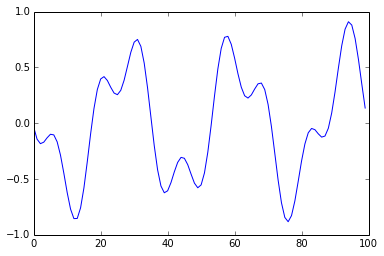

In [43]:
sine = random_sine(3, 100)

plt.plot(sine)

On génère un TVAR à partir de corrélations partielles choisies au hasard dans l'algorithme de Levinson.

In [44]:
def generation_TVAR(d, T, epsilon, ordre = 5):
    
    """generation des coefficients du TVAR par les corrélations partielles de l'algorithme de Levinson"""
    
    theta = np.matrix(np.zeros((d,T)))
    theta_inter = np.matrix(np.zeros((d,d)))
    X = epsilon
    
    kappa = np.zeros((d,T))
    for k in np.arange(d):
        kappa[k,:] = random_sine(ordre, T)
    
    for t in np.arange(T):
        for k in np.arange(d):
            theta_inter[k,k] = kappa[k,t]
        for p in np.arange(1, d, 1):
            for k in np.arange(0, p,1):
                theta_inter[k,p] = theta_inter[k, p-1] - kappa[p,t] * theta_inter[p-1-k,p-1]
        theta[:,t] = theta_inter[:,d-1]

        X[T + t] += np.dot(X[T+t-d:T+t][::-1], theta[:,t])
        
    return X, X[T:], theta

In [45]:
d = 3
T = int(1e3)
epsilon = np.random.randn(2*T)
ordre = 4
X_tot, X, theta = generation_TVAR(d, T, epsilon, ordre)

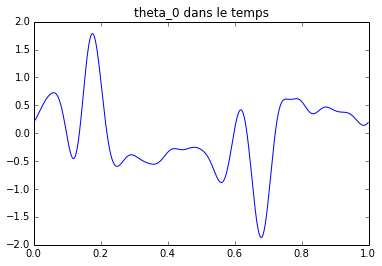

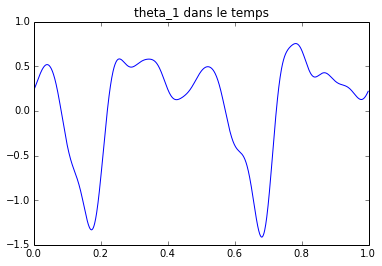

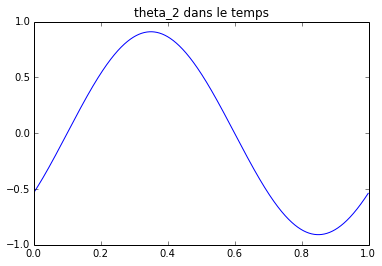

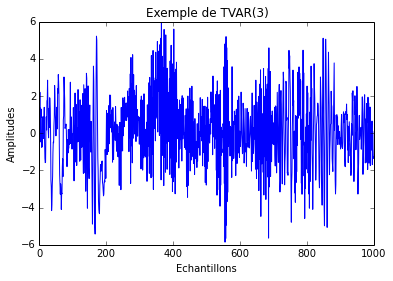

In [46]:
u = np.arange(T, dtype='double') / T

for k in np.arange(d):
    plt.figure()
    plt.plot(u, theta[k,:].T)
    plt.title("theta_{} dans le temps".format(k))
    
plt.figure()
plt.plot(np.arange(T), X)
plt.xlabel("Echantillons")
plt.ylabel("Amplitudes")
plt.title("Exemple de TVAR({})".format(d))
plt.show()

### Construction d'un estimateur en ligne

On construit dans cette partie un estimateur de notre processus TVAR(d) à partir de l'algorithme du LMS. On normalise la descente de gradient pour adapter à chaque étape le coefficient de descente que nous appelerons $\mu$ par la suite à la norme des échantillons à estimer.

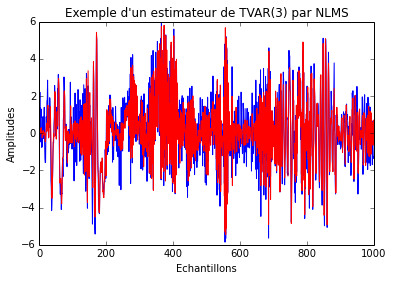

In [47]:
X_est, theta_est = generation_est(X_tot, d, T, 0.05)

plt.plot(X)
plt.plot(X_est, 'r')
plt.xlabel("Echantillons")
plt.ylabel("Amplitudes")
plt.title("Exemple d'un estimateur de TVAR({}) par NLMS".format(d))

#### Influence du paramètre $\mu$ sur $\hat\theta$ pour une trajectoire

In [48]:
def gener_beta(beta0,N):
    beta = np.zeros(N)
    for i in np.arange(N):
        beta[i] = i*beta0/N
    return beta

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer

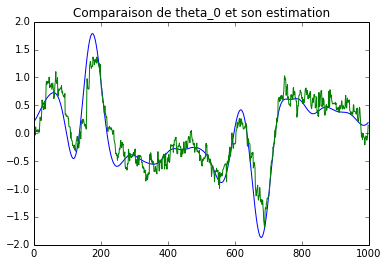

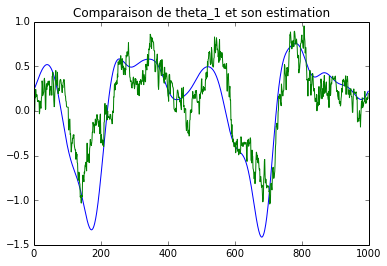

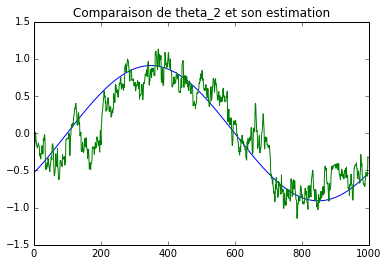

In [49]:
# Estimation
log_mu = np.arange(-3, 0, 0.3)
N = np.ceil(np.log(T)) 
beta = gener_beta(0.5,N)
mu = np.power(T, -2*beta/(2*beta+1))

estimations = np.matrix(np.zeros((N, T)))
MSE = np.zeros((N,T/2))
MISE = np.zeros(N)

for k in np.arange(N):
    estimations[k,:], theta_est = generation_est(X_tot, d, T, mu[k])
    for t in np.arange(T/2):
        MSE[k,t] = norm(theta[:,T/2 + t] - theta_est[:, T/2 + t])**2
    MISE[k] = 2./T*np.sum(MSE[k,:])
    
    if k == N-3:
        for k in np.arange(d):
            plt.figure()
            plt.plot(np.arange(T), theta[k,:].T)
            plt.plot(np.arange(T), theta_est[k,:].T)
            plt.title("Comparaison de theta_{} et son estimation".format(k))
            plt.show()

    
    #plt.figure()
    #plt.plot(estimations[k,:].T, 'r')
    #plt.plot(X)
    #plt.xlabel("Echantillons")
    #plt.ylabel("Amplitudes")
    #plt.title("Estimation pour mu = {}".format(mu[k]))

#### Influence de $\mu$ sur l'erreur d'estimation pour M trajectoires

In [50]:
M = 100
err_estim = np.matrix(np.zeros((M, N)))
err_pred = np.matrix(np.zeros((M, N)))

for l in np.arange(M):
    epsilon = np.random.randn(2*T)
    Xtot, X, theta = generation_TVAR(d, T, epsilon)
    for k in np.arange(N):
        X_pred, theta_est = generation_est(Xtot, d, T, mu[k])
        err_estim[l,k] = 2./T*norm(theta[:,T/2:] - theta_est[:, T/2:])**2
        err_pred[l,k] = 2./T*norm(X[T/2:] - X_pred[T/2:])**2

MSE_estim = np.mean(err_estim,axis=0)
MSE_pred = np.mean(err_pred,axis=0)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


KeyboardInterrupt: 

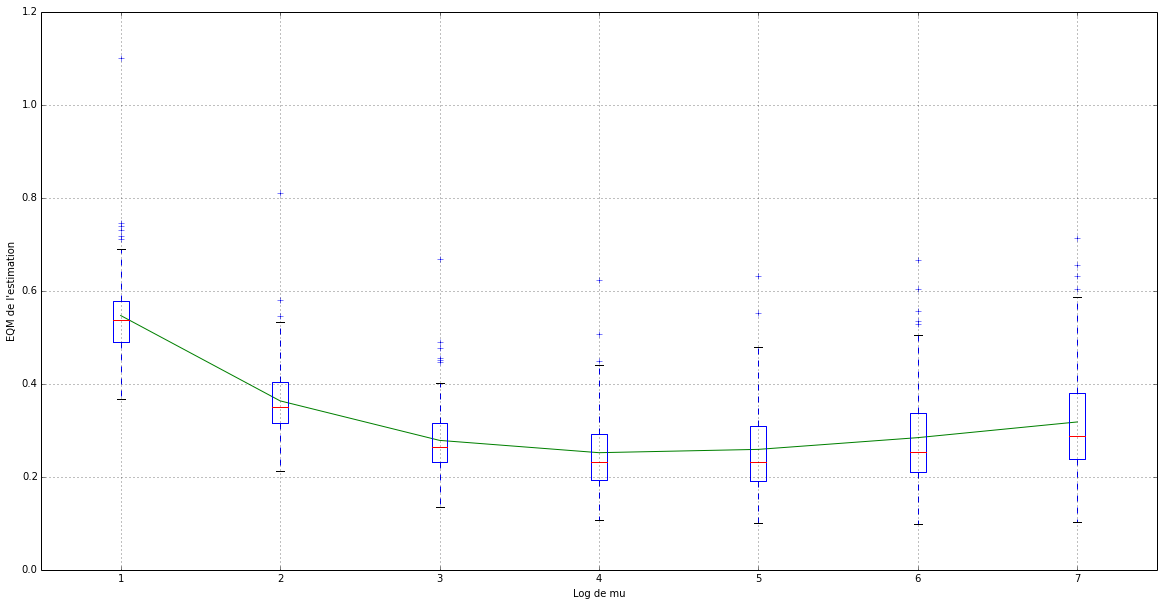

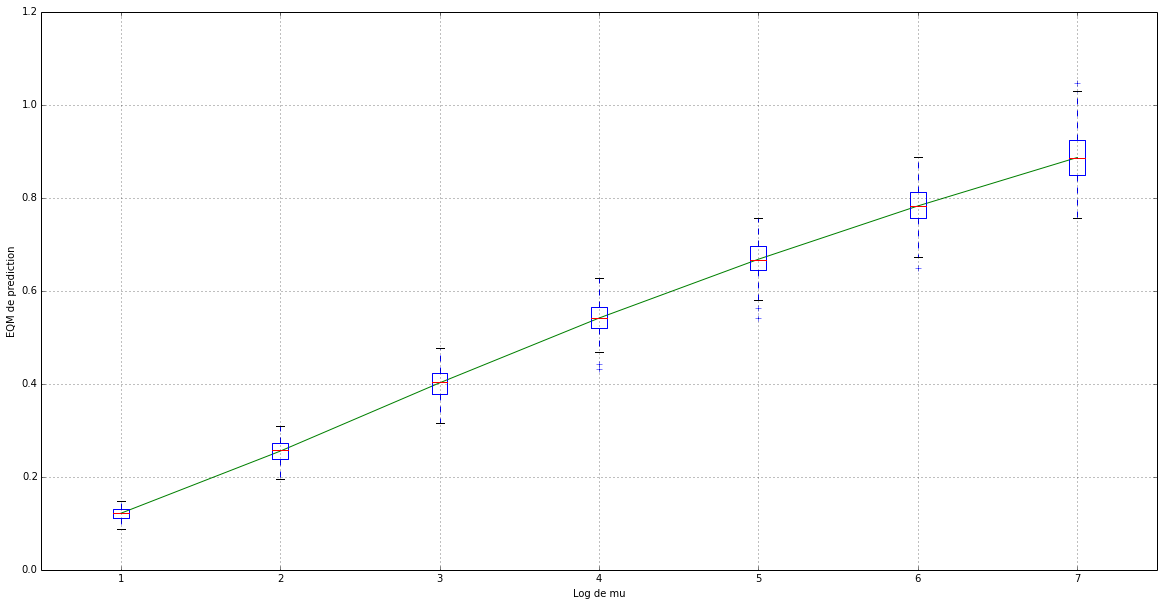

In [13]:
num =  np.arange(N) + 1

plt.figure(figsize=(20,10))
plt.plot(num, MSE_estim.T, 'g')
plt.boxplot(err_estim, positions = num, widths = 0.1*np.ones(N))
plt.xlabel("Log de mu")
plt.ylabel("EQM de l'estimation")
plt.grid(True)
plt.show()

plt.figure(figsize=(20,10))
plt.plot(num, MSE_pred.T, 'g')
plt.boxplot(err_pred, positions = num, widths = 0.1*np.ones(N))
plt.xlabel("Log de mu")
plt.ylabel("EQM de prediction")
plt.grid(True)
plt.show()

Le pas de descente $\mu$ joue donc un rôle dans la qualité de l'estimateur. Ici, on observe très bien que la valeur optimale de $\mu$ se situe aux alentoure de 0,01.

### Estimation par aggregation

Maitenant qu'on a construit un estimateur par NLMS, on se propose de construire un prédicteur par aggrégation à partir de ces estimateurs comme il est indiqué dans "Giraud, Roueff and Sanchez-Perez (2015)".

#### Erreur de prédiction

On se propose dans cette sous-partie de voir dans quelles mesures le prédicteur par aggrégation obtenu dans la partie précédente est plus efficace que les estiamteurs NLMS simples. 

In [55]:
def aggregation(X, predictions, estimations, d, T, eta, strategy = 1):    
    """Retourne un predicteur par aggregation"""   
    N = len(predictions[:,0])
    pred = np.zeros(T,dtype='double')
    estim = np.zeros((d,T),dtype='double')
    alpha = 1./N * np.ones(N)   
    
    for t in np.arange(T): 
        
        if t > 0:
            v = np.zeros(N)
            if strategy == 1:
                for i in np.arange(N):
                    v[i] = alpha[i] * np.exp(-2*eta*(pred[t-1]-X[t-1])*predictions[i,t-1])
            else:
                for i in np.arange(N):
                    v[i] = alpha[i] * np.exp(-eta*(predictions[i,t-1]-X[t-1])**2)
            
            for i in np.arange(N):
                alpha[i] = v[i] / np.sum(v)

        for n in np.arange(N):
            pred[t] += alpha[n]*predictions[n,t]
            estim[:,t] += alpha[n]*estimations[n,:,t]
        
    return pred, estim, alpha




In [52]:
def aggregation_estim(X, predictions, estimations, d, T, eta, strategy = 1):    
    """Retourne un predicteur par aggregation"""   
    N = len(predictions[:,0])
    pred = np.zeros(T,dtype='double')
    estim = np.zeros((d,T),dtype='double')
    alpha = 1./N * np.ones(N)   
    
    for t in np.arange(T): 
        
        if t > 0:
            v = np.zeros(N)
            
            if strategy == 1:
                for i in np.arange(N):
                    v[i] = alpha[i] * np.exp(-2*eta*norm(estim[:,t-1]-X[:,t-1])*norm(estimations[i,:,t-1]))
            else:
                for i in np.arange(N):
                    v[i] = alpha[i] * np.exp(-eta*norm(estimations[i,:,t-1]-X[:,t-1])**2)
            
            for i in np.arange(N):
                alpha[i] = v[i] / np.sum(v)

        for n in np.arange(N):
            pred[t] += alpha[n]*predictions[n,t]
            estim[:,t] += alpha[n]*estimations[n,:,t]
        
    return pred, estim, alpha


In [63]:
d = 3
T = int(2**10)

M = 100
N = np.ceil(np.log(T)) 
beta = gener_beta(0.5,N)
mu = 0.5*np.power(T, -2*beta/(2*beta+1))

err_estim = np.zeros((M, N))
err_estim_agr1 = np.zeros((M, 1))
err_estim_agr2 = np.zeros((M, 1))

err_pred = np.zeros((M, N))
err_pred_agr1 = np.zeros((M, 1))
err_pred_agr2 = np.zeros((M, 1))

eta = np.sqrt(np.log(np.ceil(np.log(T)))/T)

for l in np.arange(M):
    
    #Partie estimation
    epsilon = np.random.randn(2*T)
    Xtot, X, theta = generation_TVAR(d, T, epsilon)
    X_pred = np.zeros((N,T))
    theta_est = np.zeros((N,d,T))

    for k in np.arange(N):
        X_pred[k,:], theta_est[k,:,:] = generation_est(Xtot, d, T, mu[k])
        
        for t in np.arange(T/2):
            err_estim[l,k] += norm(theta[:,T/2+t] - theta_est[k,:,T/2+t])**2
            err_pred[l,k] += (X[T/2+t] - X_pred[k,T/2+t])**2
            
        err_estim[l,k] /= T/2
        err_pred[l,k] /= T/2
    
    #Partie prediction par agregation
    #agreg1, estim1, alpha1 = aggregation(X, X_pred, theta_est, d, T, eta, 1)
    #agreg2, estim2, alpha2 = aggregation(X, X_pred, theta_est, d, T, eta, 2)
    
    agreg1, estim1, alpha1 = aggregation_estim(theta, X_pred, theta_est, d, T, eta, 1)
    agreg2, estim2, alpha2 = aggregation_estim(theta, X_pred, theta_est, d, T, eta, 2)
    
    for t in np.arange(T/2):
        err_estim_agr1[l] += norm(theta[:,T/2+t] - estim1[:,T/2+t])**2
        err_estim_agr2[l] += norm(theta[:,T/2+t] - estim2[:,T/2+t])**2
    
        err_pred_agr1[l] += (X[T/2+t] - agreg1[T/2+t])**2
        err_pred_agr2[l] += (X[T/2+t] - agreg2[T/2+t])**2
        
    err_estim_agr1[l] /= T/2
    err_estim_agr2[l] /= T/2
    err_pred_agr1[l] /= T/2
    err_pred_agr2[l] /= T/2
    
MSE_estim = [np.mean(err_estim[:,k]) for k in np.arange(N)]
MSE_estim_agr1 = np.mean(err_estim_agr1)
MSE_estim_agr2 = np.mean(err_estim_agr2)

MSE_pred = [np.mean(err_pred[:,k]) for k in np.arange(N)]
MSE_pred_agr1 = np.mean(err_pred_agr1)
MSE_pred_agr2 = np.mean(err_pred_agr2)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integ

In [64]:
print(alpha1)
print(alpha2)

[  1.11257814e-18   3.16810841e-14   3.65503259e-11   2.20272184e-08
   1.21069955e-05   4.82570515e-03   9.95162166e-01]
[  1.36236731e-14   2.39764227e-07   2.17232061e-04   5.22170048e-03
   4.21581767e-02   2.17501920e-01   7.34900731e-01]


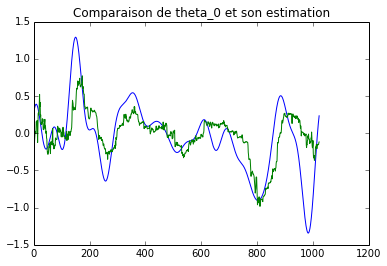

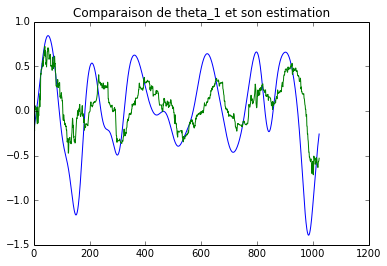

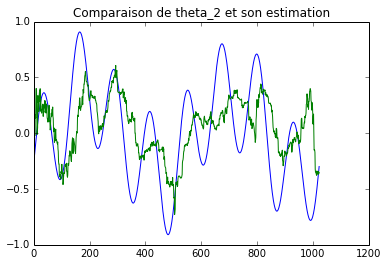

In [65]:
for k in np.arange(d):    
    plt.figure()
    plt.plot(np.arange(T), theta[k,:].T)
    plt.plot(np.arange(T), estim1[k,:].T)
    plt.title("Comparaison de theta_{} et son estimation".format(k))
    plt.show()

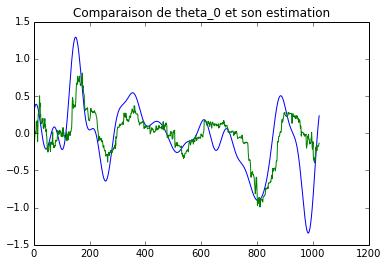

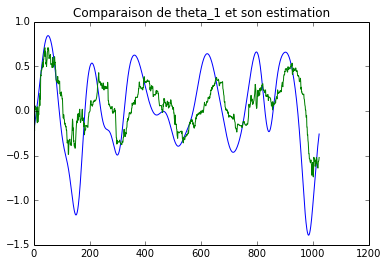

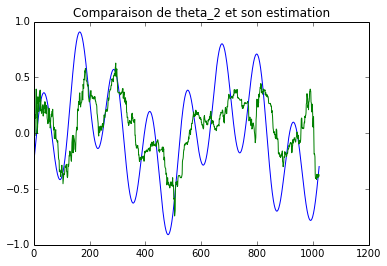

In [66]:
for k in np.arange(d):    
    plt.figure()
    plt.plot(np.arange(T), theta[k,:].T)
    plt.plot(np.arange(T), estim2[k,:].T)
    plt.title("Comparaison de theta_{} et son estimation".format(k))
    plt.show()

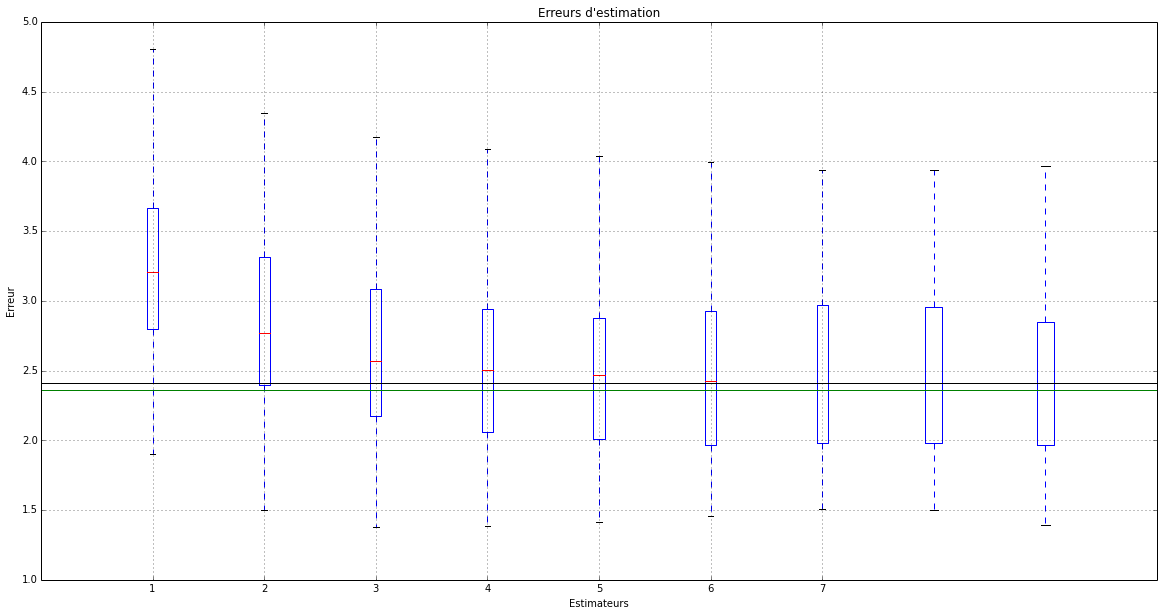

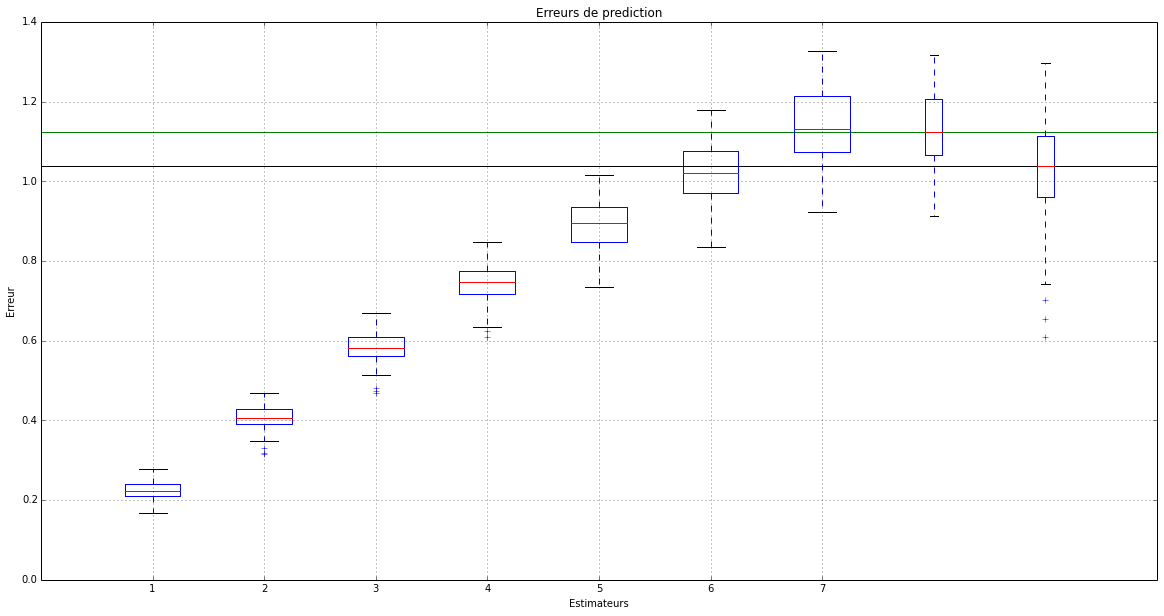

In [67]:
num = np.arange(N) + 1

median1 = np.median(err_estim_agr1)
median2 = np.median(err_estim_agr2)

plt.figure(figsize=(20,10))
#plt.plot(num, np.log(MSE_estim), 'g')
 
plt.boxplot(err_estim_agr1, positions = [N+1])
plt.boxplot(err_estim_agr2, positions = [N+2])
plt.boxplot(err_estim, positions = num, widths = 0.1 * np.ones(N))

plt.axhline(y=median1, color ='g')
plt.axhline(y=median2, color='k')

plt.title("Erreurs d'estimation")
plt.xlabel("Estimateurs")
plt.ylabel("Erreur")
plt.xlim(0,N+3)
plt.grid(True)
plt.show()


median1 = np.median(err_pred_agr1)
median2 = np.median(err_pred_agr2)

plt.figure(figsize=(20,10))
#plt.plot(num, np.log(MSE_pred), 'g')
plt.axhline(y=median1, color ='g')
plt.axhline(y=median2, color='k')

plt.boxplot(err_pred_agr1, positions = [N+1])
plt.boxplot(err_pred_agr2, positions = [N+2]) 
plt.boxplot(err_pred, positions = num)

plt.title("Erreurs de prediction")
plt.xlabel("Estimateurs")
plt.ylabel("Erreur")
plt.xlim(0,N+3)
plt.grid(True)
plt.show()

In [62]:
print(MSE_pred_agr1)
print(MSE_pred_agr2)
print(min(MSE_pred))

0.22830994916
0.227924906702
0.227322110647


On remarque que le prédicteur par aggrégation donne lieu à une EQM plus faible que les EQM offertes par les estimateurs par NLMS classiques.

### Analyse spectrale

In [ ]:
from scipy.fftpack import fft

def dsp(theta, T, N = 512):
    dsp_array = np.matrix(np.zeros((N, T)))
    
    for t in np.arange(T):
        dsp_array[:,t] = np.matrix(1./abs(fft(theta[:,t].T, N)) ** 2).T
        
    lambd = np.arange(N, dtype = 'double')/N
        
    return lambd, dsp_array

#### Estimation paramétrique

In [ ]:
N = 2**12

coeffs = np.ones((d+1,T))
coeffs[1:,:] = -theta #polynome caractértistique

coeffs_est = np.ones((d+1,T))
coeffs_est[1:,:] = -theta_est #polynome caractértistique

f, dsp_X = dsp(coeffs, T, N)
f, dsp_X_est = dsp(coeffs_est, T, N)


roots = np.roots(coeffs[:,T/2][::-1])
angles = (np.angle(roots) + np.pi) / (2*np.pi)

print("Les racines du polynome caractéristique sont :")
for k in np.arange(d):
    print("{} de phase {}".format(roots[k], angles[k]))

        
lambd = np.arange(N, dtype = 'double') / N

plt.figure()
plt.plot(lambd, dsp_X[:,T/2]/np.max(abs(dsp_X[:,0])), 'b', label ='vraie DSP')
for k in np.arange(d):
    if angles[k] >=0 and angles[k] <=0.5:
        plt.axvline(x=angles[k]+0.5, ymin=0, ymax=1, linewidth=1, color = 'r')
    else:
        plt.axvline(x=angles[k]-0.5, ymin=0, ymax=1, linewidth=1, color = 'r')
plt.xlabel("Frequences reduites")
plt.ylabel("Amplitudes")
plt.title("DSP et racines du polynome caracteristique")

plt.figure()
plt.plot(lambd, dsp_X_est[:,T/2]/np.max(abs(dsp_X_est[:,0])), 'b', label = 'DSP estimee')
for k in np.arange(d):
    if angles[k] >=0 and angles[k] <=0.5:
        plt.axvline(x=angles[k]+0.5, ymin=0, ymax=1, linewidth=1, color = 'r')
    else:
        plt.axvline(x=angles[k]-0.5, ymin=0, ymax=1, linewidth=1, color = 'r')
plt.xlabel("Frequences reduites")
plt.ylabel("Amplitudes")
plt.title("DSP estimee et racines du polynome caracteristique")

#### Estimation non-paramétrique

In [ ]:
from scipy.signal import periodogram

N = 2**12

f, Pxx = periodogram(X, nfft = N)
f, Pxx_est = periodogram(X_est, nfft = N)

plt.figure()
plt.plot(f, Pxx/np.max(abs(Pxx)), 'b', label ='vraie DSP')
for k in np.arange(d):
    if angles[k] >= 0.5 and angles[k] <= 1:
        plt.axvline(x=angles[k] - 0.5, ymin=0, ymax=1, linewidth=1, color = 'r')
plt.title("Periodogramme des observations")
        
plt.figure()
plt.plot(f, Pxx_est/np.max(abs(Pxx_est)), 'b', label = 'DSP estimee')
for k in np.arange(d):
    if angles[k] >= 0.5 and angles[k] <= 1:
        plt.axvline(x=angles[k] - 0.5, ymin=0, ymax=1, linewidth=1, color = 'r')
plt.title("Periodogramme de l'estimation")

charger aeiou
tracer son spectrogramme
faire un predicteur par agregation
trouver son theta chapeau (dot(alpha, theta))
tracer le spectrogramme de la dsp dans le temps et comparer les deux
trouver le pitch en faisant la différence du spctrogramme avec le spectrogramme estimé